In [1]:
# Raw Package
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sma
import pmdarima as pmd

from sklearn.preprocessing import StandardScaler
import datetime as dt

import warnings
warnings.filterwarnings(action='ignore')
# pd.set_option('max_columns', 150)
# pd.set_option('max_rows', 150)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def analysis(ticker, period, interval, stma=True, start_date=None, 
             sma=20, lma=50, figsize=(12,6), threads=False):
    '''works best on days and not time intervals between days
       sma = short moving average length
       lma = long moving average length
    '''
    item = yf.download(tickers=ticker, period=period, interval=interval, threads=threads)
    print(item.shape)
    if start_date is None:
        start_date = item.index[0]

    price_min = item.Close.min()
    price_max = item.Close.max()
    diff = price_max - price_min
    level1 = price_max - 0.236 * diff
    level2 = price_max - 0.382 * diff
    level3 = price_max - 0.618 * diff

    level_price = pd.DataFrame( columns = ['Level','Price'])
    level_price.loc["0.0"] = price_max
    level_price.loc["0.236"] = level1
    level_price.loc["0.382"] = level2
    level_price.loc["0.618"] = level3
    level_price.loc["1.0"] = price_min
    print(level_price)

    rolls = item.Close.rolling(sma).mean().to_frame()
    rolls.columns = ['r{}'.format(sma)]
    rolls['r{}'.format(lma)] = item.Close.rolling(lma).mean()
    rolls['sign'] = np.sign(rolls['r{}'.format(lma)]-rolls['r{}'.format(sma)])
    rolls['sign_s'] = rolls.sign.shift(1)
    rolls['intx'] = np.where(rolls.sign != rolls.sign_s, 1, 0)

    fig, ax=plt.subplots(1,1,figsize=(12,6))
    item.Close.loc[start_date:].plot(ax=ax, color='k')
    if stma == True:
        item.Close.rolling(20).mean().loc[start_date:].plot(ax=ax, style=['b:'])
        item.Close.rolling(50).mean().loc[start_date:].plot(ax=ax, style=['r:'])
        for idx in rolls[rolls.intx==1].loc[start_date:].index:
            ax.axvline(idx, color='k', alpha=0.5)
    ax.axhspan(level1, price_min, alpha=0.4, color='lightsalmon')
    ax.axhspan(level2, level1, alpha=0.5, color='palegoldenrod')
    ax.axhspan(level3, level2, alpha=0.5, color='palegreen')
    ax.axhspan(price_max, level3, alpha=0.5, color='powderblue')
#     ax.set_xticklabels(item.Close.index.values, {'fontsize':10, 'rotation':45})
    plt.title(ticker)
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.legend(['Close Price','Short','Long'], loc=2);   
    
    return item

def weighted_mean(x,w):
    return np.sum(w*x)/np.sum(w)

### Fibonacci Retracements in Python

- https://blog.quantinsti.com/fibonacci-retracement-trading-strategy-python/
- https://towardsdatascience.com/fibonacci-retracements-in-python-470eb33b6362

In [3]:
# amc = analysis('AMC', period='365d', interval='1d', start_date=dt.datetime(2021,1,1)) #pd.to_datetime('2021-01-01'))

amc = analysis('AMC', period='365d', interval='1d', start_date='2021-01-01')

AttributeError: 'Index' object has no attribute 'tz_localize'

- https://medium.com/geekculture/the-fibonacci-rsi-an-interesting-combination-in-trading-a1c118b9a317
- https://medium.com/swlh/creating-a-variable-rsi-for-dynamic-trading-a-study-in-python-2af3ff8eaf0c

In [4]:
def rsi(x, n=14, low=30, high=70, ra='standard'):
    '''Calculates RSI'''
    delta = x['Close'].diff().dropna()
    dUp, dDown = delta.clip(lower=0), delta.clip(upper=0)

    if ra == 'standard':
        RolUp = dUp.rolling(n).mean() #pd.rolling_mean(dUp, n)
        RolDown = dDown.abs().rolling(n).mean() #pd.rolling_mean(dDown, n).abs()
    else:
        RolUp = dUp.ewm(span=n).mean()
        RolDown = dDown.abs().ewm(span=n).mean()

    RS = RolUp / RolDown
    rsi= 100.0 - (100.0 / (1.0 + RS))
    
    fig, ax=plt.subplots(1,1,figsize=(12,6))
    rsi.plot(ax=ax);
    ax.axhspan(low, 0, alpha=0.1, color='g')
    ax.axhspan(100, high, alpha=0.1, color='r')
    ax.axhline(50,color='k', alpha=0.2)
    ax.legend(['RSI','','Overbought - Sell','Oversold - Buy'])
    ax.set_title("RSI  N={}  Roll={}".format(n,ra));
    
    return rsi

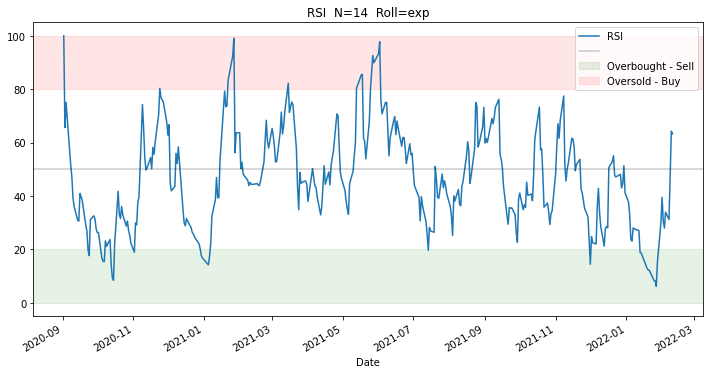

In [5]:
rsi(amc, low=20, high=80, ra='exp');

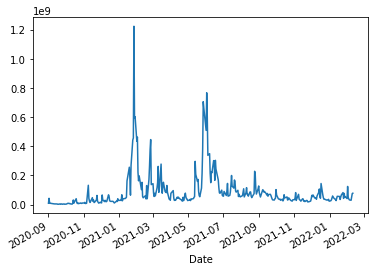

In [6]:
amc.Volume.plot();

In [7]:
amc['Returns'] = amc.Close.pct_change()

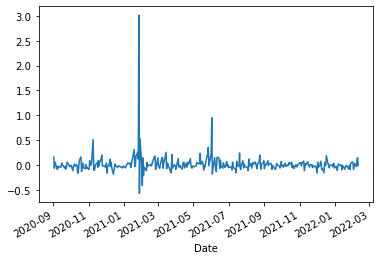

In [8]:
amc.Returns.plot();

- https://medium.com/analytics-vidhya/exploring-stock-data-with-a-yahoo-finance-python-module-319c6b3815ae
- https://github.com/RyanElliott10
- https://algotrading101.com/learn/yahoo-finance-api-guide/

In [9]:
amc2 = yf.Ticker('AMC')

In [10]:
amc2.info

HTTPError: HTTP Error 404: Not Found

In [ ]:
# amc2.

In [ ]:
prices = amc2.history(period='6mo')
prices.head()

In [ ]:
prices['Returns'] = prices['Close'].pct_change()
prices.head()

In [11]:
amc2.institutional_holders

HTTPError: HTTP Error 404: Not Found

In [ ]:
amc2.options

In [12]:
# option_chain = amc2.option_chain(date='2021-06-04')
# option_chain.calls.sort_values('lastTradeDate')

In [13]:
# option_chain.puts

- https://www.investopedia.com/ask/answers/122414/what-are-most-common-periods-used-creating-moving-average-ma-lines.asp#:~:text=Crossovers%20of%20the%2050%2Dday,.)%20to%20select%20moving%20averages.
- https://towardsdatascience.com/predicting-short-term-stock-movements-with-quantitative-finance-and-machine-learning-in-python-e6e04e3e0337

- When long crosses over short, SELL
- When short crosses over long, BUY
- 50 day by 10 or 20 are considered signifcant


- https://medium.com/coinmonks/legacy-banking-consumes-twice-as-much-energy-as-bitcoin-5b439fe10240

The first retracement level at 23.6% is \\$15.67, the second retracement level at 38.6\% is \\$13.05, and the next retracement level at 61.8\% is \\$8.82. 

**How to use the Fibonacci retracement trading strategy?**

The retracement levels can be used in a situation where you wanted to buy a particular stock but you have not been able to because of a sharp run-up in the stock price. In such a situation, wait for the price to correct to Fibonacci retracement levels such as 23.6\%, 38.2\%, and 61.8\% and then buy the stock.The ratios 38.2\% and 61.8\% are the most important support levels.

This Fibonacci retracement trading strategy is more effective over a longer time interval and like any indicator, using the strategy with other technical indicators such as RSI, MACD, and candlestick patterns can improve the probability of success.

**Should be below $8.82 to buy again.**

In [9]:
amc_ap = np.array([15.95,8,10.72]) 
amc_shr = np.array([5,5,10]) 

amc_ap = np.array([15.95,8,10.72,9.90])
amc_shr = np.array([5,5,10,10])

amc_ap = np.array([15.95,8,10.72,9.90,9.89]) # 4.13.2021
amc_shr = np.array([5,5,10,10,5])

wt_prc = weighted_mean(amc_ap, amc_shr)
print("Current Avg Cost = ${:.2f}".format(wt_prc))

des_prc = 169 #18 #13.4

net = des_prc*amc_shr.sum() - wt_prc*amc_shr.sum()

print("Desired Return at ${:.2f} = ${:.2f}".format(des_prc, net))

print("Current Return = ${:.2f}".format( amc.Close[-1]*amc_shr.sum() - wt_prc*amc_shr.sum()))

Current Avg Cost = $10.73
Desired Return at $169.00 = $5539.60
Current Return = $283.65


In [10]:
amc.Close.values[-1]

18.82990074157715

In [11]:
190/2.205/16.4

5.254134173994801

In [12]:
117000/52/40

56.25

In [13]:
def odds2prob(x):
    return x/(x+1)

In [14]:
print(odds2prob(13.5) * 100)

print(odds2prob(0.95) * 100)

93.10344827586206
48.717948717948715


### BITCOIN

[*********************100%***********************]  1 of 1 completed
(360, 6)
              Level         Price
0.0    67566.828125  67566.828125
0.236  58655.590734  58655.590734
0.382  53142.706586  53142.706586
0.618  44231.469195  44231.469195
1.0    29807.347656  29807.347656


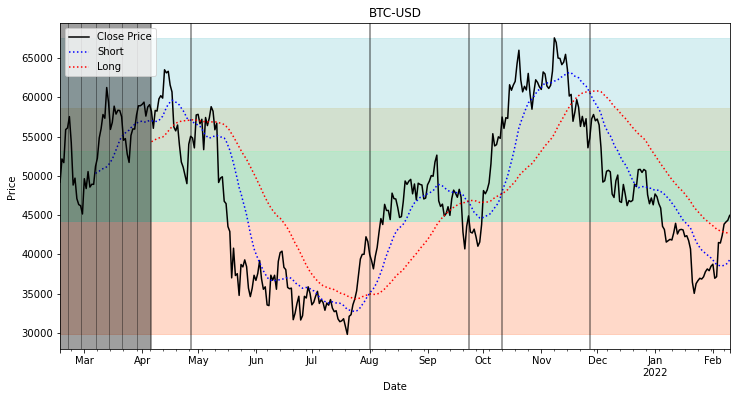

In [15]:
btc = analysis('BTC-USD','360d','1d',start_date='2021-01-01')

Looks bad for BTC and shows I probably should have sold...

In [16]:
my_btc = 0.01030852
btc_prc_paid = 100.01
btc_price = btc.Close[-1]
print("Capping at $39k gets me $300 profit.")
print(btc_price)
print("BTC RETURN = ${:,.2f}".format(btc_price * my_btc - 100.01))

Capping at $39k gets me $300 profit.
44957.6015625
BTC RETURN = $363.44


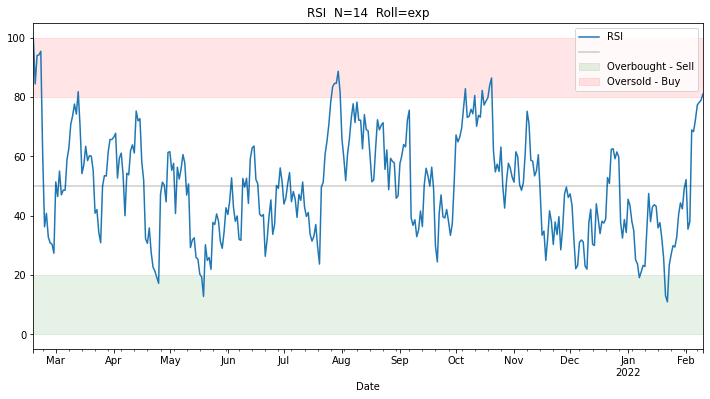

In [17]:
rsi(btc, low=20, high=80, ra='exp');

[*********************100%***********************]  1 of 1 completed
(2704, 6)


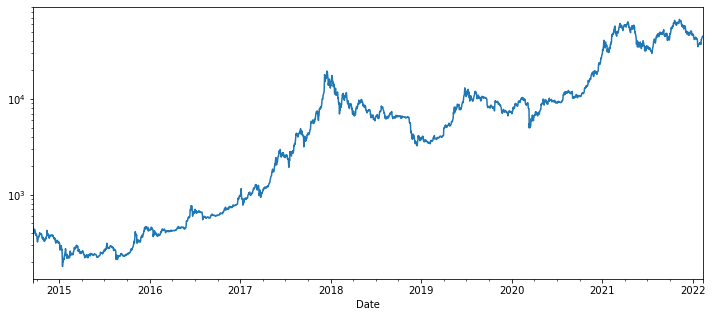

In [18]:
btc2 = yf.download(tickers='BTC-USD', period='5000d', interval='1d')
print(btc2.shape)
fig, ax=plt.subplots(1,1,figsize=(12,5))
btc2.Close.plot(ax=ax)
ax.set_yscale('log');

In [19]:
btc3 = yf.download(tickers='BTC-USD', period='3mo', interval='1h', aut_adjust=True)
print(btc3.shape)

[*********************100%***********************]  1 of 1 completed
(2198, 6)


In [25]:
# help(yf.download)

In [26]:
# btc3.head(24)

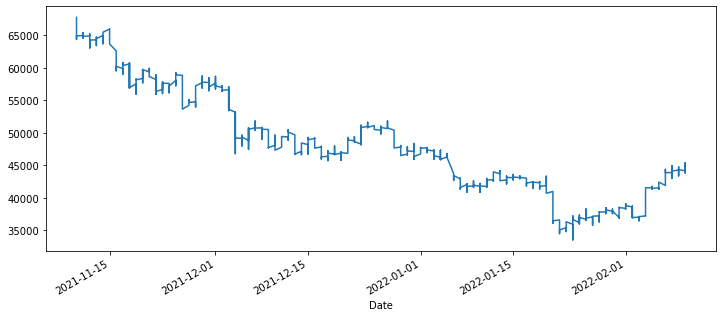

In [20]:
fig, ax=plt.subplots(1,1,figsize=(12,5))
btc3.Close.plot(ax=ax);

### CARDANO

[*********************100%***********************]  1 of 1 completed
(360, 6)
          Level     Price
0.0    2.968239  2.968239
0.236  2.473279  2.473279
0.382  2.167075  2.167075
0.618  1.672115  1.672115
1.0    0.870951  0.870951


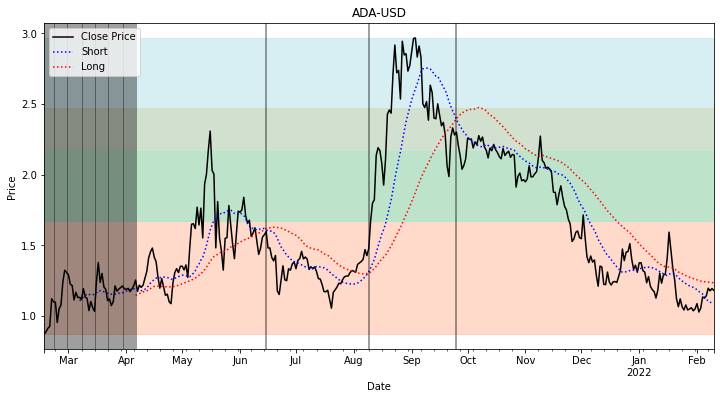

In [21]:
ada = analysis('ADA-USD','360d','1d',start_date='2021-01-01')

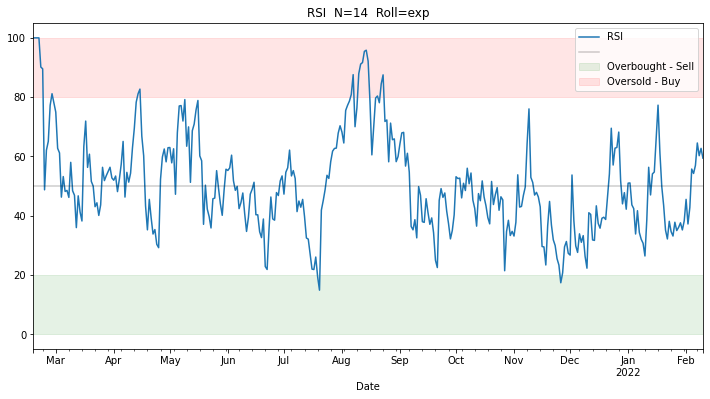

In [22]:
rsi(ada, low=20, high=80, ra='exp');

### DOGE

[*********************100%***********************]  1 of 1 completed
(360, 6)
          Level     Price
0.0    0.684777  0.684777
0.236  0.534354  0.534354
0.382  0.441296  0.441296
0.618  0.290873  0.290873
1.0    0.047392  0.047392


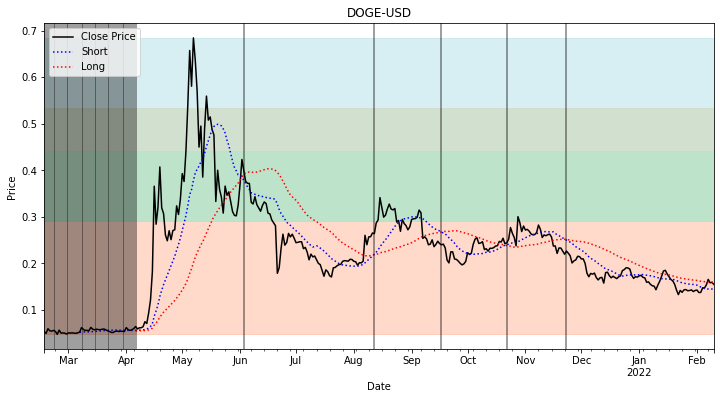

In [23]:
doge = analysis('DOGE-USD','360d','1d',start_date='2021-01-01', sma=20)

- long over short is time to sell... this doesnt look good for doge...

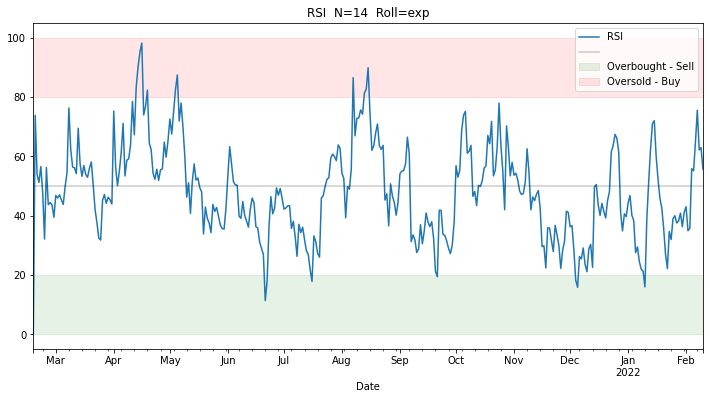

In [24]:
rsi(doge, low=20, high=80, ra='exp');

### ALGORAND

[*********************100%***********************]  1 of 1 completed
(325, 6)
          Level     Price
0.0    2.379480  2.379480
0.236  1.982463  1.982463
0.382  1.736852  1.736852
0.618  1.339835  1.339835
1.0    0.697207  0.697207


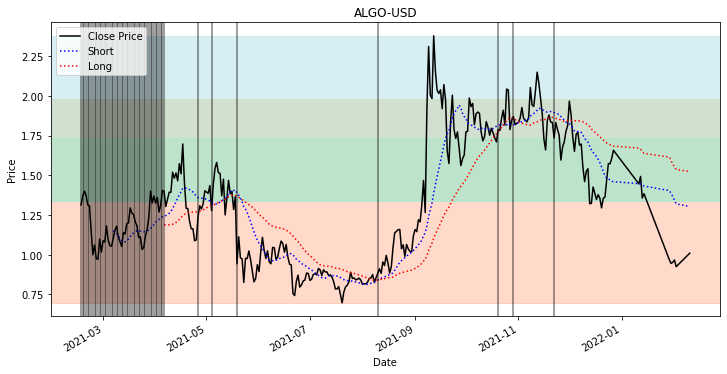

In [25]:
algo = analysis('ALGO-USD','360d','1d',start_date='2021-01-01', sma=10)

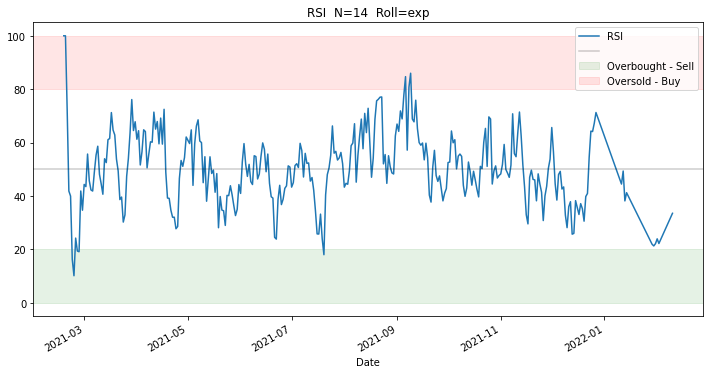

In [26]:
rsi(algo, low=20, high=80, ra='exp');

### AMC GME Comparison

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
          gme       amc
gme  1.000000  0.774104
amc  0.774104  1.000000


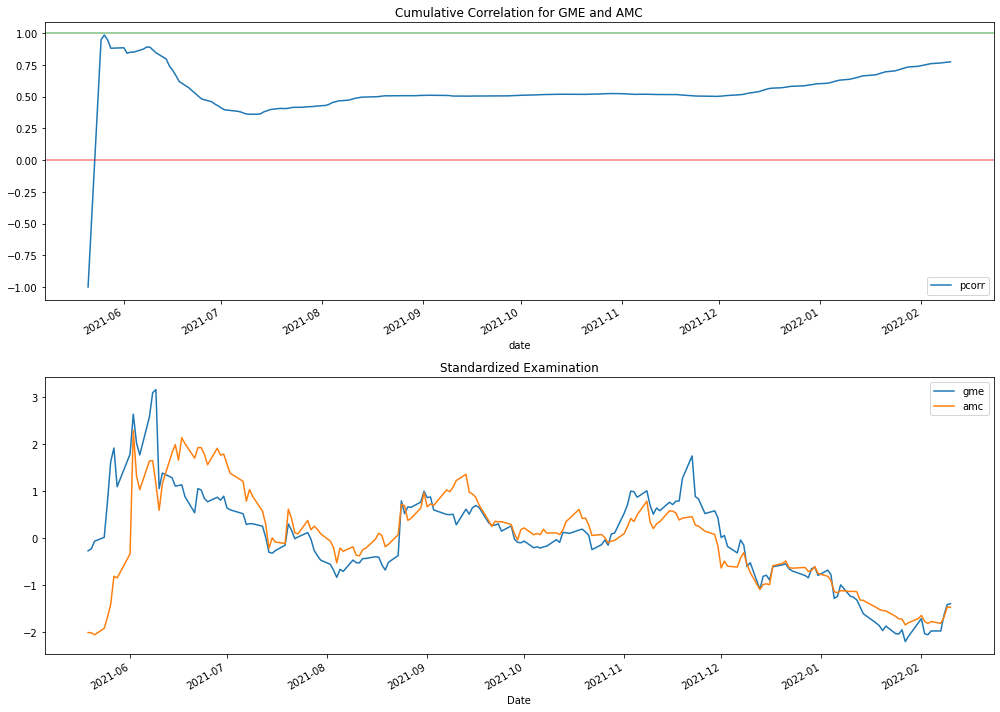

In [27]:
gme_6m = yf.download(tickers='GME', period='186d', interval='1d')
amc_6m = yf.download(tickers='AMC', period='186d', interval='1d')

## scaled analysis
ss = StandardScaler()
full = pd.concat([gme_6m['Adj Close'], amc_6m['Adj Close'], #nok_ac, 
                 ], axis=1)
full_ss = pd.DataFrame(ss.fit_transform(full.dropna()), index=gme_6m.index, 
                       columns=['gme','amc', #'nok',
                                ])

## correlations running
pcorrs = []
for idx in full_ss.index[2:]:
#     print("Corr Up to {}  =  {:.4f} ".format(idx, full_ss.loc[:idx].corr().values[0,1]))
    pcorrs.append([idx, full_ss.loc[:idx].corr().values[0,1]])

pcdf = pd.DataFrame(pcorrs, columns=['date','pcorr']).set_index('date')
print(full_ss.corr())

fig, ax=plt.subplots(2,1,figsize=(14,10))
pcdf.plot(ax=ax[0]);
ax[0].axhline(0,c='r',alpha=0.5);
ax[0].axhline(1,c='g',alpha=0.5);
ax[0].set_title("Cumulative Correlation for GME and AMC");

full_ss.plot(ax=ax[1]);
ax[1].set_title("Standardized Examination");
plt.tight_layout()


### nokia

In [28]:
nok = yf.download(tickers='NOK', period='183d', interval='1d')

[*********************100%***********************]  1 of 1 completed


In [29]:
nok_ac = nok['Adj Close']
print(nok_ac.mean())

nok_model = sma.OLS(endog=nok_ac, exog=np.ones(nok_ac.shape)).fit()
nok_pred = pd.DataFrame(nok_model.predict(), index=nok_ac.index)

nok_ar = pmd.auto_arima(y=nok_ac, max_p=28, max_d=1, max_q=28, #seasonal = True, m=7, 
                        out_of_sample_size=14)
nok_ar_pred = pd.DataFrame(nok_ar.predict_in_sample(), index=nok_ac.index)

5.743786863941964


In [30]:
nok_forc = pd.DataFrame(nok_ar.predict(28),
                        index=pd.date_range(start=nok_ac.index[-1]+pd.offsets.Day(1), 
                                            freq='D', periods=28))

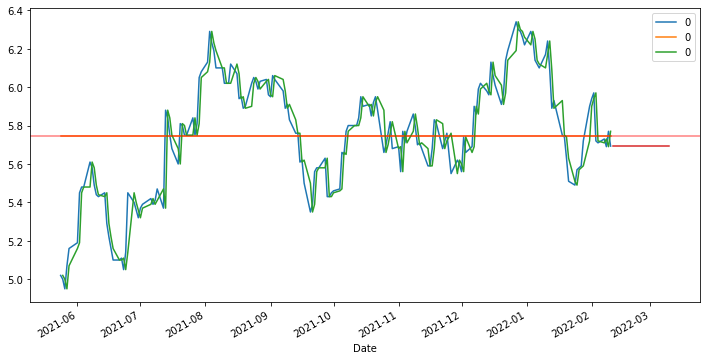

In [31]:
fig, ax=plt.subplots(1,1,figsize=(12,6))
nok_ac.plot(ax=ax)
nok_pred.plot(ax=ax)
nok_ar_pred.iloc[1:].plot(ax=ax)
nok_forc.plot(ax=ax)
ax.axhline(nok_ac.mean(), c='r', alpha=0.5);

**Nokia forecast now sits at a higher mean!**

### Crypto Fear and Greed Index

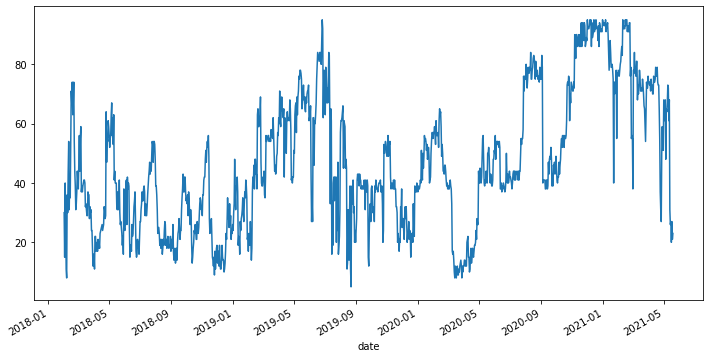

In [39]:

# import requests
# import json

# fgi = 'https://api.alternative.me/fng/?limit=0&format=csv&date_format=us'
# response = requests.get(fgi)
# # parsed = json.loads(response.text)
# print(response.text)


fgi = pd.read_csv('fgi.csv')
fgi.index = pd.to_datetime(fgi['date'])
fgi.sort_index(inplace=True)

fig, ax=plt.subplots(1,1,figsize=(12,6))
fgi.fng_value.plot(ax=ax);

### Fib on COIN

[*********************100%***********************]  1 of 1 completed
(60, 6)
            Level       Price
0.0    346.519989  346.519989
0.236  304.908471  304.908471
0.382  279.165752  279.165752
0.618  237.554234  237.554234
1.0    170.199997  170.199997


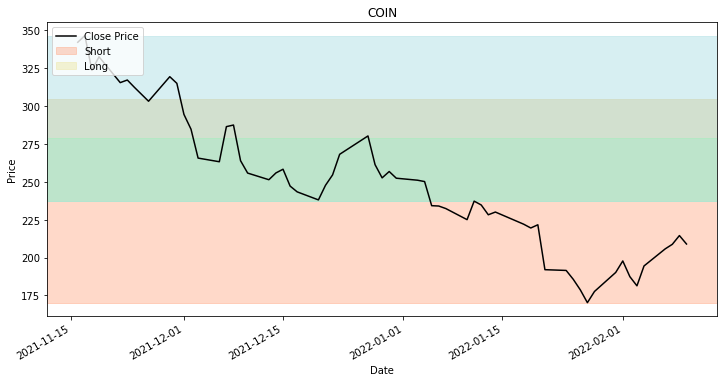

In [32]:
coin = analysis('COIN','60d','1d',stma=False,)

In [32]:
# mnmd = analysis('MNMD', period='30d', interval='1d', stma=False)

In [41]:
# chk = yf.download(tickers='ADA', period='30d', interval='1d')

## ADA
market_cap = 55.7e9
total_locked_value = 

print("${:,.2f}".format(market_cap))

SyntaxError: invalid syntax (<ipython-input-41-89d9fcc8d7ab>, line 5)